# Gérémy Michaud

<h1 style="text-align:center">Travail pratique numérique en thermodynamique statistique</h1>
<h2 style="text-align:center">PARTIE 2 : Modèle de Drude</h2>

Veuillez indiquer le nom des membres de votre équipe dans la cellule suivante.

- Pierre-Olivier Desrosiers<br>
- Nicolas Dorval<br>
- Gérémy Michaud<br>
- Félix-Antoine Dupuis

# Introduction # 
Cette deuxième partie du travail implémente une simulation 2D du modèle de Drude pour décrire le mouvement des électrons libres et indépendants dans les métaux. Des sphères dures sont encore utilisées pour représenter les particules, mais maintenant de deux types différents afin de différencier les coeurs ioniques immobiles des électrons sur leurs trajectoires balistiques. Les collisions entre les deux doivent donc être inélastiques. Les questions sur cette simulation, d'abord de cinétique puis de dynamique des électrons en présence d'une force externe appliquée au cristal, vérifieront quelques résultats analytiques du modèle de Drude obtenus en classe et/ou dans le manuel de cours Ashcroft/Mermin.

- **La remise du présent _Jupyter Notebook_ ET celui de la 1<sup>re</sup> partie, ainsi que tout autre fichier de code produit, se fait sur Gradescope en n'oubliant pas d'y indiquer tous les membres de votre équipe.**

In [ ]:
from numpy import *
import random
from vpython import *
from IPython.display import display, Math
import math
import matplotlib.pyplot as plt
import time

# 2<sup>e</sup> partie - Modèle de Drude #

Faites une copie du script `TDS-2Dsimulation_HXX.py` et modifiez-le pour obtenir une simulation cinétique d'un gaz d'électrons libres dans la matière cristalline selon le modèle de Drude. Spécifiquement selon les pp.4-6 du manuel Ashcroft/Mermin,
1. ajoutez un deuxième type de sphères fixes réparties périodiquement dans la boîte d'animation: celles-ci représenteront les coeurs ioniques,
2. éliminez les collisions entre les sphères mobiles qui représentent maintenant les électrons de conduction indépendants et libres,
3. en faisant appel à la température du gaz, ajoutez des collisions inélastiques entre les électrons libres et les coeurs ioniques fixes. La quantité de mouvement $\vec{p}$ n'est alors PAS conservée et il faut appliquer les hypothèses spécifiques du modèle de Drude à la sortie de chaque collision, notamment: 
- la direction de $\vec{p}$ doit être aléatoire,
- la norme $||\vec{p}||$ est déterminée par la distribution de Maxwell-Boltzmann.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

### Votre simulation ###

VII. _(25 points)_ &mdash; Écrivez un appel de votre nouveau script pour l'exécuter avec la cellule suivante:

In [1]:
from test4 import Simulation
liste_p_avg, liste_pos_avg = Simulation(0,700)

In [ ]:
from test3 import DrudeModelSimulator

pavg_list, posavg_list = DrudeModelSimulator()

### Question statistique ###

VIII. _(5 points)_ &mdash; Vérifiez numériquement et graphiquement que l'amortissement de la quantité de mouvement moyenne des électrons suit l'équation exponentielle dérivée analytiquement en classe, soit $\langle p(t)\rangle =\langle p(t_0)\rangle \,e^{-t/\tau}$, et comparez-y le comportement d'un seul électron.

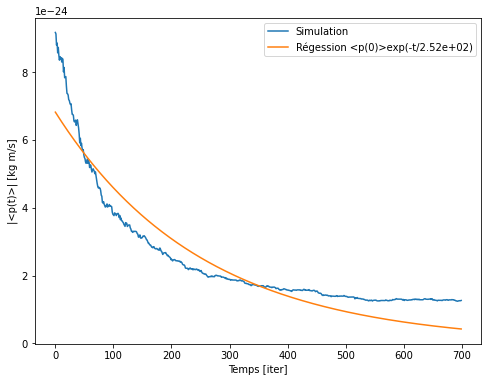

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
time = np.arange(0,700,1)
equation = lambda x, tau, a: a*np.exp(-x/tau)
popt, pcov = curve_fit(equation, time, liste_p_avg, p0=[1, liste_p_avg[0]])
plt.figure(figsize=(8, 6))
plt.plot(time, np.array(liste_p_avg), label="Simulation")
plt.plot(time, equation(time, *popt), label=f"Régession <p(0)>exp(-t/{popt[0]:0.2e})")
plt.legend()
plt.xlabel("Temps [iter]")
plt.ylabel("|<p(t)>| [kg m/s]")
plt.show()

### Dynamique sous l'effet d'une force externe ###

IX. _(10 points)_ &mdash; Pour passer de la cinétique à la dynamique des électrons libres, modifiez votre code de simulation en ajoutant une fonction qui applique un champ électrique uniforme. Celui-ci devra être de module ajustable et perpendiculaire à deux des côtés de la boîte. À chaque pas de temps $\mathrm{d}t$ sans collision, les électrons devront donc accélérer d'un incrément $\mathrm{d}p_x$ dicté par la force de Coulomb à leur position.

Copiez le code de votre fonction dans la cellule qui suit en n'oubliant pas d'inclure votre fichier Python (`.py`) modifié avec la simulation complète lors de la remise.

### Question statistique ###

X. _(5 points)_ &mdash; Pour quelques différents modules de champ électrique, présentez graphiquement l'évolution de la position moyenne des électrons en fonction du temps pour ses deux composantes parallèle et perpendiculaire au champ.

# Médiagraphie #
- P. Drude, _Zur Elektronentheorie der Metalle; I Teil_, Annalen der Physik **306**(3), pp.566–613 (1900) https://doi.org/10.1002/andp.19003060312
- P. Drude, _Zur Elektronentheorie der Metalle; II Teil. Galvanomagnetische und Thermomagnetische Effecte_, Annalen der Physik **308**(11), pp.369–402 (1900) https://doi.org/10.1002/andp.19003081102
- P. Drude, _Zur Elektronentheorie der Metalle; Berichtigung_, Annalen der Physik **312**(3), pp.687–692 (1902) https://doi.org/10.1002/andp.19023120312
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies I_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.438-453 (1905) https://dwc.knaw.nl/DL/publications/PU00013989.pdf
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies II_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.585-593 (1905) https://dwc.knaw.nl/DL/publications/PU00014010.pdf
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies III_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.684-691 (1905) https://dwc.knaw.nl/DL/publications/PU00014024.pdf
- La simulation utilise la librairie <a href="https://vpython.org">VPython</a> conçue pour faciliter la visualisation de physique en 3D, avec les instructions d’installation <a href="https://vpython.org/presentation2018/install.html">ici</a> et la documentation <a href="https://www.glowscript.org/docs/VPythonDocs/index.html">ici</a>. Le code adapte en 2D et commente en détail l’exemple <a href="https://www.glowscript.org/#/user/GlowScriptDemos/folder/Examples/program/HardSphereGas-VPython">HardSphereGas-VPython</a> du site interactif <a href="https://www.glowscript.org">GlowScript</a> pour programmer des animations avec VPython directement en ligne.